In [21]:
%%time

from statsmodels.nonparametric.smoothers_lowess import lowess

from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from astropy.constants import c
from scipy.stats import norm
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os

pd.set_option('max_colwidth', 15)
warnings.filterwarnings('ignore')

CPU times: user 100 µs, sys: 46 µs, total: 146 µs
Wall time: 149 µs


In [3]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [4]:
def pix_to_wl(pix, wl0, dwl):
    return wl0 + pix * dwl

In [5]:
os.environ['NUMEXPR_MAX_THREADS'] = '35' #change this number using the correct number of cores/threads in jupyter.slurm

In [6]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [7]:
stars = sorted(glob.glob('/store/teams/cosmos/hill/hill_extern7bis/LP/LPgiants/*/'))[:-1]

In [8]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn.csv')
cayrel['path'] = stars

In [9]:
wmin_O = 6295 #AA
wmax_O = 6305 #AA
wmin_Na = 5885 #AA
wmax_Na = 5900 #AA
wmin_Al = 3955 # 3940 #AA
wmax_Al = 3965 #AA

In [10]:
linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))

[2025-04-11 16:34:28,497] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


In [11]:
linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))
ll = pd.DataFrame(ValdFile('linelist/O_VALD_all.lin'))
# ll_ch = pd.DataFrame(ValdFile('linelist/CH_VALD_all.lin'))
# ll_cn = pd.DataFrame(ValdFile('linelist/CN_VALD_all.lin'))
linelist = pd.concat([linelist, ll.query('6295 < wlcent < 6305 and gflog > -10')])
linelist = LineList(linedata=linelist.sort_values(by='wlcent', ascending=True), medium='air').sort()

print('Number of lines in the linelist: %d' %linelist.species.size)

[2025-04-11 16:34:30,541] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


[2025-04-11 16:34:30,999] [INFO] [vald:loads:174]: Loading VALD file linelist/O_VALD_all.lin


INFO - Loading VALD file linelist/O_VALD_all.lin
Number of lines in the linelist: 2903


In [22]:
pd.DataFrame(linelist).query('species == "Fe 1"')

,species,wlcent,gflog,excit,j_lo,e_upp,j_up,lande_lower,lande_upper,lande,...,gamvw,depth,reference,couple_lower,term_lower,couple_upper,term_upper,error,atom_number,ionization
0,Fe 1,3801.67917,-1.022,2.8316,2.0,6.0920,3.0,1.50,1.21,0.92,...,-7.739,0.228,E 0.045 ...,LS,3d7.(4P).4s...,LS,3d6.(3F2).4...,1.096478,1.0,1.0
1,Fe 1,3801.80857,-1.485,2.8450,1.0,6.1053,2.0,1.49,0.95,0.69,...,-7.800,0.086,_ ...,LS,3d7.(4P).4s...,LS,3d6.(3F2).4...,0.500000,1.0,1.0
2,Fe 1,3801.98338,-1.010,3.3320,5.0,6.5921,6.0,1.40,1.32,1.13,...,-7.224,0.079,N C ...,LS,3d6.(5D).4s...,LS,3d7.(4F).4d...,0.250000,1.0,1.0
3,Fe 1,3802.27779,-1.214,3.3009,2.0,6.5608,2.0,1.18,1.50,1.34,...,-7.686,0.054,E 0.053 ...,LS,3d7.(2D2).4...,LS,3d7.(2D2).4...,1.122018,1.0,1.0
4,Fe 1,3804.00893,-1.040,3.3320,5.0,6.5904,4.0,1.40,1.44,1.33,...,-7.225,0.074,N C ...,LS,3d6.(5D).4s...,LS,3d7.(4F).4d...,0.250000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,Fe 1,6430.84463,-2.006,2.1759,3.0,4.1034,4.0,1.67,1.50,1.24,...,-7.704,0.116,N B+ ...,LS,3d7.(4P).4s...,LS,3d7.(4F).4p...,0.070000,1.0,1.0
2877,Fe 1,6494.97996,-1.273,2.4041,6.0,4.3125,5.0,1.16,1.22,1.03,...,-7.629,0.283,N B+ ...,LS,3d6.4s2 a3H,LS,3d7.(4F).4p...,0.070000,1.0,1.0
2893,Fe 1,6546.23723,-1.536,2.7586,3.0,4.6520,2.0,0.76,0.69,0.82,...,-7.626,0.079,E 0.083 ...,LS,3d7.(2G).4s...,LS,3d7.(4F).4p...,1.202264,1.0,1.0
2901,Fe 1,6592.91200,-1.473,2.7275,4.0,4.6076,3.0,1.05,1.09,1.00,...,-7.633,0.096,E 0.045 ...,LS,3d7.(2G).4s...,LS,3d7.(4F).4p...,1.096478,1.0,1.0


In [18]:
pd.DataFrame(linelist).query('species == "Fe 1"').depth.size

513

In [33]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [34]:
#SME parallel and init functions

In [188]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include, wl_min, wl_max):

    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/Cayrel_ONaAl.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'spline+mask'
    sme.fitresults.maxiter = 100

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.ones(wave.size)
    line_regions[sme.spec.data == 0.0] = 0
    line_regions[(sme.spec.data > np.percentile(sme.spec.data, 45)) & (sme.spec.data < np.percentile(sme.spec.data, 85))] = 2
    line_regions = line_regions.astype(int)
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist[(linelist.wlcent > wl_min) & (linelist.wlcent < wl_max)]

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #Fixed values from pysme
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    
    return sme

In [189]:
def sme_parallel(i, input_row, elems_to_include, vrad_flag, ipress, wl_min, wl_max, is_nlte, tol=1e-5):

    #Load data to create SME structures
    if 'Al 1' in elems_to_include:
        header_spb = pd.read_csv('%s/spb' %input_row.path, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
        data_spb = pd.read_csv('%s/spb' %input_row.path, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
        data_spb.dropna(axis=0, inplace=True)
        
        wave_spb = pix_to_wl(data_spb.pix.values, header_spb.wl0.values[0], header_spb.dwl.values[0]) * np.sqrt((1.-(header_spb.rv[0]*1000.)/c.value)/(1.+(header_spb.rv[0]*1000.)/c.value))
        spec_spb = data_spb.flux.values/10000.
        uncs_spb = 0.001*np.ones_like(data_spb.flux.values)
    
    if 'O 1' in elems_to_include:
        return

    if 'Na 1' in elems_to_include:
        return
        
    wave = wave_spb[(wave_spb > wl_min) & (wave_spb < wl_max)]
    spec = spec_spb[(wave_spb > wl_min) & (wave_spb < wl_max)]
    uncs = 1./uncs_spb[(wave_spb > wl_min) & (wave_spb < wl_max)]

    #Renormalisation for Al
    if 'Al 1' in elems_to_include: spec = spec/lowess(spec, wave, frac=0.2, it=15)[:, 1]
    spec = spec + (1. - np.median(spec))

    del wave_spb, spec_spb, uncs_spb

    #input from pysme
    teff = input_row.teff
    logg = input_row.logg
    monh = input_row.monh
    vmic = input_row.vmic
    vmac = input_row.vmac

    sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress = ipress, vrad_bounds = (-1,1), elems_to_include = elems_to_include, wl_min=wl_min, wl_max=wl_max)
    del wave, spec, uncs

    sme.abund.update_pattern({'Fe':input_row.fe})
    if 'Al 1' in elems_to_include: sme.abund.update_pattern({'C':input_row.c})

    #NLTE
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    if is_nlte and ('Al 1' in elems_to_include): sme.nlte.set_nlte('Al', 'nlte_Al_pysme.grd')
    if is_nlte and ('Na 1' in elems_to_include): sme.nlte.set_nlte('Na', 'nlte_Na_pysme.grd')
    if is_nlte and ('O 1'  in elems_to_include): sme.nlte.set_nlte('O' , 'nlte_O_pysme.grd')
    
    #Do the heavy lifting with
    if 'Al 1' in elems_to_include: fitparameters = ['abund Al']
    if 'Na 1' in elems_to_include: fitparameters = ['abund Na']
    if 'O 1'  in elems_to_include: fitparameters = ['abund O']
    
    sme = solve(sme, fitparameters)

    elem, eelem_sme, eelem_fit, n_iter_elem = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations
    eelem_rms = eelem_sme
    
    sme.save('sme_save/cayrel_elem_%s_lines_%s' %(elems_to_include[0].replace(' ', '').lower(), input_row.spec_id))
    del sme

    if 'Al 1' in elems_to_include:
        columns = ['spec_id', 'al1', 'eal1_rms', 'eal1_sme', 'n_lines_al1', 'min_iters_al1']
        n_lines = 2
    if 'Na 1' in elems_to_include:
        columns = ['spec_id', 'na1', 'ena1_rms', 'ena1_sme', 'n_lines_na1', 'min_iters_na1']
        n_lines = 2
    if 'O 1'  in elems_to_include:
        columns = ['spec_id', 'o1',  'eo1_rms',  'eo1_sme',   'n_lines_o1', 'min_iters_o1' ]
        n_lines = 1
    
    data_to_write = np.vstack((input_row.spec_id, elem, eelem_rms, eelem_sme, n_lines, n_iter_elem)).T
    del elem, eelem_sme, eelem_fit, n_iter_elem

    pd.DataFrame(data=data_to_write, columns=columns).to_csv('abunds_merged/cayrel_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower(), index=False, header=False, mode='a')
    del data_to_write

    return

In [190]:
# def sme_parallel_nlte(i, input_row, elems_to_include, vrad_flag, ipress, wl_min, wl_max, is_nlte, tol=1e-5):

#     #Load data to create SME structures
#     if 'Al 1' in elems_to_include:
#         spectra = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
#         spectra.waveobs = spectra.waveobs * 10.
#         spectra.err[spectra.err == 0.0] = 1.0
    
#     if 'O 1' in elems_to_include:
#         spectra = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
#         spectra.waveobs = spectra.waveobs * 10.
#         spectra.err[spectra.err == 0.0] = 1.0

#     if 'Na 1' in elems_to_include:
#         spectra = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
#         spectra.waveobs = spectra.waveobs * 10.
#         spectra.err[spectra.err == 0.0] = 1.0
        
#     wave = spectra.waveobs[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]
#     spec = spectra.flux[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]
#     uncs = 1./spectra.err[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]

#     #Renormalisation for Al
#     if 'Al 1' in elems_to_include: spec = spec/lowess(spec, wave, frac=0.2, it=15)[:, 1]
#     spec = spec + (1. - np.median(spec))

#     del spectra

#     #input from pysme
#     teff = input_row.teff
#     logg = input_row.logg
#     monh = input_row.monh
#     vmic = input_row.vmic
#     vmac = input_row.vmac

#     sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress = ipress, vrad_bounds = (-1,1), elems_to_include = elems_to_include, wl_min=wl_min, wl_max=wl_max)
#     del wave, spec, uncs

#     sme.abund.update_pattern({'Fe':input_row.fe})
#     if 'Al 1' in elems_to_include: sme.abund.update_pattern({'C':input_row.c})

#     #NLTE
#     # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
#     if 'Al 1' in elems_to_include: sme.nlte.set_nlte('Al', 'nlte_Al_pysme.grd')
#     if 'Na 1' in elems_to_include: sme.nlte.set_nlte('Na', 'nlte_Na_pysme.grd')
#     if 'O 1'  in elems_to_include: sme.nlte.set_nlte('O' , 'nlte_O_pysme.grd')
    
#     #Do the heavy lifting with
#     if 'Al 1' in elems_to_include: fitparameters = ['abund Al']
#     if 'Na 1' in elems_to_include: fitparameters = ['abund Na']
#     if 'O 1'  in elems_to_include: fitparameters = ['abund O']
    
#     sme = solve(sme, fitparameters)

#     elem, eelem_sme, eelem_fit, n_iter_elem = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations
#     eelem_rms = eelem_sme
    
#     sme.save('sme_save/uves_elem_%s_nlte_lines_%s' %(elems_to_include[0].replace(' ', '').lower(), input_row.spec_id))
#     del sme

#     if 'Al 1' in elems_to_include:
#         columns = ['spec_id', 'al1', 'eal1_rms', 'eal1_sme', 'n_lines_al1', 'min_iters_al1']
#         n_lines = 2
#     if 'Na 1' in elems_to_include:
#         columns = ['spec_id', 'na1', 'ena1_rms', 'ena1_sme', 'n_lines_na1', 'min_iters_na1']
#         n_lines = 2
#     if 'O 1'  in elems_to_include:
#         columns = ['spec_id', 'o1',  'eo1_rms',  'eo1_sme',   'n_lines_o1', 'min_iters_o1' ]
#         n_lines = 1
    
#     data_to_write = np.vstack((input_row.spec_id, elem, eelem_rms, eelem_sme, n_lines, n_iter_elem)).T
#     del elem, eelem_sme, eelem_fit, n_iter_elem

#     pd.DataFrame(data=data_to_write, columns=columns).to_csv('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower(), index=False, header=False, mode='a')
#     del data_to_write

#     return

In [210]:
# %%time

# elems_to_include = ['Al 1']
# vrad_flag = 'whole'
# ipress = 47000
# tol = 1e-8
# sme = sme_parallel(34, cayrel.iloc[34], elems_to_include=elems_to_include, vrad_flag=vrad_flag, ipress=ipress, tol=tol, wl_min=wmin_Al, wl_max=wmax_Al, is_nlte=False)

In [211]:
%%time

ipress = 42000
tol = 1e-8

elems_to_include = ['Al 1']
vrad_flag = 'whole'
if os.path.exists('abunds_merged/cayrel_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
    os.system('rm abunds_merged/cayrel_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower())

Parallel(n_jobs=1, verbose=2)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
                                                     ipress=ipress, tol=tol, wl_min=wmin_Al, wl_max=wmax_Al, is_nlte=False) for i, input_row in cayrel.iterrows())
!sed -i '1i \spec_id,al1,eal1_rms,eal1_sme,n_lines_al1,min_iters_al1' abunds_merged/cayrel_lines_al1_merged.csv

# elems_to_include = ['Na 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_Na, wl_max=wmax_Na, is_nlte=False) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,na1,ena1_rms,ena1_sme,n_lines_na1,min_iters_na1' abunds_merged/uves_lines_na1_merged.csv

# elems_to_include = ['O 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_O, wl_max=wmax_O, is_nlte=False) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,o1,eo1_rms,eo1_sme,n_lines_o1,min_iters_o1' abunds_merged/uves_lines_o1_merged.csv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


CPU times: user 10min 26s, sys: 1.55 s, total: 10min 28s
Wall time: 10min 35s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 10.6min finished


In [21]:
# %%time

# ipress = 42000
# tol = 1e-8

# elems_to_include = ['Al 1']
# vrad_flag = 'whole'
# if os.path.exists('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower())

# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel_nlte)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_Al, wl_max=wmax_Al, is_nlte=True) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,al1_nlte,eal1_nlte_rms,eal1_nlte_sme,n_lines_al1_nlte,min_iters_al1_nlte' abunds_merged/uves_lines_al1_nlte_merged.csv

# elems_to_include = ['Na 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel_nlte)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_Na, wl_max=wmax_Na, is_nlte=True) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,na1_nlte,ena1_nlte_rms,ena1_nlte_sme,n_lines_na1_nlte,min_iters_na1_nlte' abunds_merged/uves_lines_na1_nlte_merged.csv

# elems_to_include = ['O 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel_nlte)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_O, wl_max=wmax_O, is_nlte=True) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,o1_nlte,eo1_nlte_rms,eo1_nlte_sme,n_lines_o1_nlte,min_iters_o1_nlte' abunds_merged/uves_lines_o1_nlte_merged.csv

In [18]:
#Plotting 

In [203]:
sme = SME_Structure.load('sme_save/cayrel_elem_al1_lines_35_CS31082_01.sme')

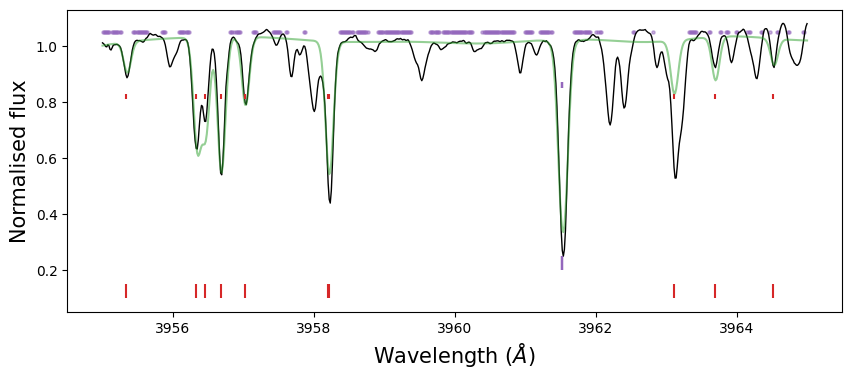

In [204]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot(sme.wave.data, sme.spec.data, lw=1, color='k')
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1.5, alpha=0.5)

elem_to_plot = 'Al 1'
for wline, species, depth in sme.linelist[['wlcent', 'species', 'depth']]:

    if elem_to_plot in species:
        plt.vlines(wline, 0.2, 0.25, color='C4')
        plt.vlines(wline, 0.85, 0.87, color='C4')
    else:
        plt.vlines(wline, 0.1, 0.15, color='C3')
        plt.vlines(wline, 0.81, 0.83, color='C3')
        # plt.annotate(text='%s' %species, xy=(wline-0.15, 0.05), rotation=90)
    # plt.annotate(text='%2.3f' %depth, xy=(wline-0.15, 0.5), rotation=90)
    
# plt.scatter(sme.wave.data, sme.mask.data, color='grey', s=5, alpha=0.5)
plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2] - 0.95, color='C4', s=5, alpha=0.5)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

# plt.xlim(3943, 3945)
# plt.xlim(3955, 3965)

# plt.xlim(6297, 6303.0)
# plt.ylim(0.8, 1.05)

# plt.ylim(0.0, 1.1)
plt.show()

In [205]:
sme.fitresults.values, sme.fitresults.uncertainties, sme.fitresults.fit_uncertainties, sme.monh

(array([5.68559127]),
 array([0.43727867]),
 [0.1408651190612222],
 -2.6042612058542174)

In [206]:
sme.fitresults.values - 6.45

array([-0.76440873])

In [209]:
sme.fitresults.values + sme.monh

array([3.08133007])

In [ ]:
#LOWESS regression to fir Al continuum

In [103]:
%%time
# 2. Apply LOWESS for continuum fitting
smoothed = lowess(sme.spec.data, sme.wave.data, frac=0.2, it=15)  # frac controls smoothing

CPU times: user 225 ms, sys: 13 µs, total: 225 ms
Wall time: 227 ms


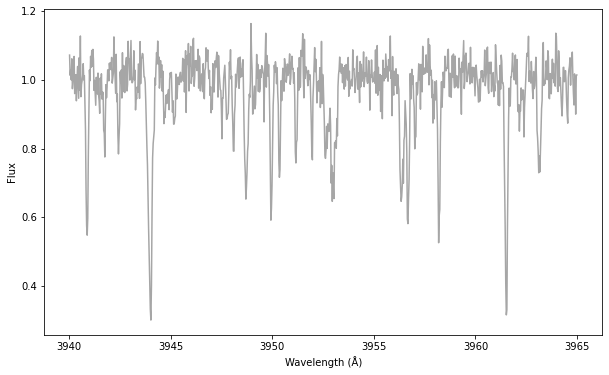

In [104]:
# 3. Plot the original spectrum and the fitted continuum
plt.figure(figsize=(10, 6))
plt.plot(sme.wave.data, sme.spec.data/smoothed[:, 1], label='Noisy Spectrum', color='gray', alpha=0.7)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.show()